In [1]:
#DESCRIPTION

#Using NLP and machine learning, make a model to identify toxic comments from the Talk edit pages on Wikipedia. Help identify the words that make a comment toxic.

#Problem Statement:  

#Wikipedia is the world’s largest and most popular reference work on the internet with about 500 million unique visitors per month. It also has millions of contributors who can make edits to pages. The Talk edit pages, the key community interaction forum where the contributing community interacts or discusses or debates about the changes pertaining to a particular topic. 

#Wikipedia continuously strives to help online discussion become more productive and respectful. You are a data scientist at Wikipedia who will help Wikipedia to build a predictive model that identifies toxic comments in the discussion and marks them for cleanup by using NLP and machine learning. Post that, help identify the top terms from the toxic comments. 

#Domain: Internet

#Analysis to be done: Build a text classification model using NLP and machine learning that detects toxic comments.

#Content: 

#id: identifier number of the comment

#comment_text: the text in the comment

#toxic: 0 (non-toxic) /1 (toxic)

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sayarsamanta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sayarsamanta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sayarsamanta/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sayarsamanta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
!pip install imbalanced-learn

In [4]:
!pip install cufflinks

In [5]:
!pip install chart_studio

In [32]:
#Import libraries
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
#from wordcloud import WordCloud
from nltk.tokenize import TweetTokenizer
import re
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV,StratifiedKFold
import seaborn as sns
from sklearn.metrics import recall_score
from imblearn.pipeline import make_pipeline
from string import punctuation
from nltk import tokenize,WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

In [7]:
df=pd.read_csv('train-2.csv')
df.head()

,id,comment_text,toxic
0,e617e2489abe9bca,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0
1,9250cf637294e09d,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0
2,ce1aa4592d5240ca,"Marya Dzmitruk was born in Minsk, Belarus in M...",0
3,48105766ff7f075b,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0
4,0543d4f82e5470b6,New Categories \r\n\r\nI honestly think that w...,0


In [8]:
#Check for null values
print("Size of data is: ", df.shape, "\n" )
print(df.isnull().sum())

Size of data is:  (5000, 3) 

id              0
comment_text    0
toxic           0
dtype: int64


In [9]:
#Drop irrelevant variables. Here Id is not required for analysis
df.drop(['id'],axis=1,inplace=True)
df.head(3)

,comment_text,toxic
0,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0
1,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0
2,"Marya Dzmitruk was born in Minsk, Belarus in M...",0


In [10]:
#Check if the label data is Balanced/Unbalanced. Checking class imbalance
df.toxic.value_counts()

0    4563
1     437
Name: toxic, dtype: int64

<AxesSubplot:xlabel='toxic', ylabel='count'>

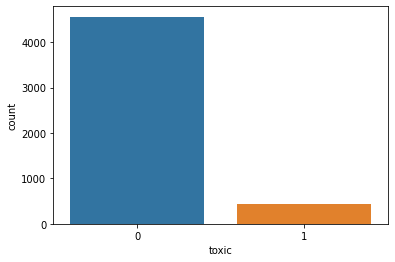

In [11]:
#Plot the label data to visualise the class imbalance
sns.countplot(x="toxic", data=df)

/Volumes/Samsung_T5/Anaconda/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


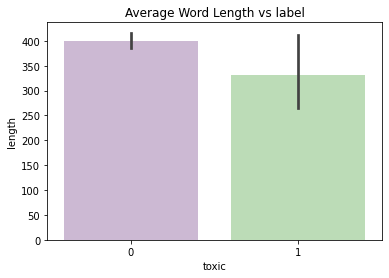

In [12]:
#Exploratory Data Analysis
df['length'] = df['comment_text'].apply(len)
fig1 = sns.barplot('toxic','length',data = df,palette='PRGn')
plt.title('Average Word Length vs label')
plot = fig1.get_figure()
plot.savefig('Barplot.png')

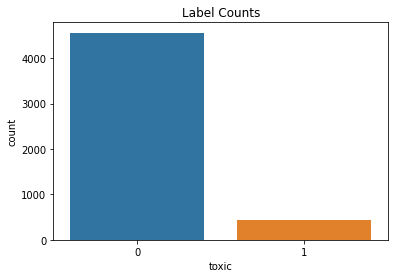

In [13]:
#bar graph to count positive negative label
fig2 = sns.countplot(x= 'toxic',data = df)
plt.title('Label Counts')
plot = fig2.get_figure()
plot.savefig('Count Plot.png')

In [28]:
def vectorization(table):
    #CountVectorizer will convert a collection of text documents to a matrix of token counts
    #Produces a sparse representation of the counts 
    #Initialize
    vector = CountVectorizer()
    #We fit and transform the vector created
    frequency_matrix = vector.fit_transform(table.toxic)
    #frequency_matrix
    #Sum all the frequencies for each word
    sum_frequencies = np.sum(frequency_matrix, axis=0)
    #Now we use squeeze to remove single-dimensional entries from the shape of an array that we got from applying np.asarray to
    #the sum of frequencies.
    corpus = [str (item) for item in sum_frequencies]
    frequency = np.squeeze(np.asarray(corpus))
    #Now we get into a dataframe all the frequencies and the words that they correspond to
    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names()).transpose()
    return frequency_df

In [29]:
def graph(word_frequency, sent):
    labels = word_frequency[0][1:51].index
    title = "Word Frequency for %s" %sent
    #Plot the figures
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(50), word_frequency[0][1:51], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(50), labels, rotation=90, size=14);
    plt.xlabel("50 more frequent words", size=14);
    plt.ylabel("Frequency", size=14);
    #plt.title('Word Frequency for %s', size=18) %sent;
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show()

In [15]:
#converting into list for better computation
data = df.comment_text.values.tolist()

In [18]:
stopwords1 = list(stopwords.words('english'))
print(stopwords1[0:11])
print('\nlength of stopwords list: ', len(stopwords1))
type(stopwords1)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've"]

length of stopwords list:  179


list

In [21]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
stopwords1 = list(stopwords.words('english'))+list(punctuation)

In [23]:
print(len(stopwords1),stopwords1,sep='\n\n')

211

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'tha

/Volumes/Samsung_T5/Anaconda/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='length', ylabel='Density'>

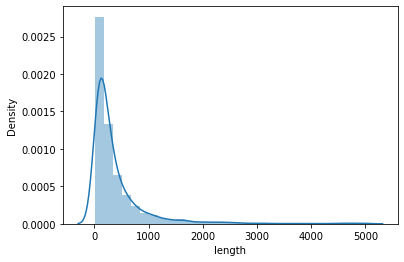

In [24]:
sns.distplot(a=df['length'],bins=30)

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

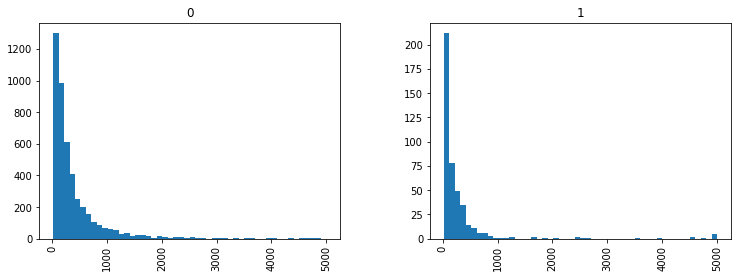

In [25]:
df.hist(column='length', by='toxic', bins=50,figsize=(12,4))

In [26]:
#removing url from text
import re

def remove_url(text_data):
  """remove_url takes raw text and removes urls from the text.
     https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105
     """
  return re.sub(r"http\S+", "", text_data)

In [27]:
df['comment_text'] = df['comment_text'].apply(remove_url)

In [28]:
#removing ip address from text
def remove_ip(text_data):
    return re.sub(r"\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b","",text_data)

In [29]:
df['comment_text'] = df['comment_text'].apply(remove_ip)

In [30]:
# Removing Stopwords and punctuatons
def clean_text(a):
    ls = [i.lower() for i in tokenize.word_tokenize(a) if i not in stopwords1]
    if len(ls)>3:
        val= ' '.join(ls)
        return val
    else :
        return None
    
    
# Lemmatization without POS Tags
def clean_text_lemma(a):
    val= ' '.join([lemmatizer.lemmatize(i.lower()) for i in tokenize.word_tokenize(a) if i not in stopwords1])
    return val


# Stemming
def clean_text_stem(a):    
    val= ' '.join([ps.stem(i.lower()) for i in tokenize.word_tokenize(a) if i not in stopwords1])
    return val

In [33]:
df['clean_txt'] = df['comment_text'].apply(clean_text)
df.dropna(inplace = True)
len(df)

4842

In [34]:
df.head()

,comment_text,toxic,length,clean_txt
0,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0,338,`` a barnstar the defender wiki barnstar i lik...
1,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0,952,`` this seems unbalanced whatever i said maths...
2,"Marya Dzmitruk was born in Minsk, Belarus in M...",0,1739,marya dzmitruk born minsk belarus march 19 199...
3,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0,37,`` talkback dear celestia ... ``
4,New Categories \r\n\r\nI honestly think that w...,0,428,new categories i honestly think need add categ...


In [36]:
#stemming and lemmatization
#here we have build a custom function that will first get the noun pos tag and then
#do the lemmatization

ps=PorterStemmer()

lemmatizer = WordNetLemmatizer()

In [38]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    
    if nltk_tag.startswith('N'):
        return wordnet.NOUN
    else:          
        return None

def lemmatize_sentence(sentence):    
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
#     print(list(nltk_tagged))
    
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)

    
    lemmatized_sentence = []   
    
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
#             print('IN CASE OF NONE: ', lemmatized_sentence)
        
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
#             print('IN CASE OF ELSE : ',lemmatized_sentence)

    
    return " ".join(lemmatized_sentence)

# print(lemmatize_sentence(" i have been working on my skills ")) #I be love it






In [39]:
df['clean_lemma'] = df['clean_txt'].apply(clean_text_lemma)
df['clean_lemma_pos'] = df['clean_txt'].apply(lemmatize_sentence)
df['clean_stem_txt'] = df['clean_txt'].apply(clean_text_stem)

In [40]:
df.head()

,comment_text,toxic,length,clean_txt,clean_lemma,clean_lemma_pos,clean_stem_txt
0,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0,338,`` a barnstar the defender wiki barnstar i lik...,`` barnstar defender wiki barnstar like edit k...,`` a barnstar the defender wiki barnstar i lik...,`` barnstar defend wiki barnstar like edit kay...
1,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0,952,`` this seems unbalanced whatever i said maths...,`` seems unbalanced whatever said mathsci said...,`` this seems unbalanced whatever i said maths...,`` seem unbalanc whatev said mathsci said far ...
2,"Marya Dzmitruk was born in Minsk, Belarus in M...",0,1739,marya dzmitruk born minsk belarus march 19 199...,marya dzmitruk born minsk belarus march 19 199...,marya dzmitruk born minsk belarus march 19 199...,marya dzmitruk born minsk belaru march 19 1992...
3,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0,37,`` talkback dear celestia ... ``,`` talkback dear celestia ... ``,`` talkback dear celestia ... ``,`` talkback dear celestia ... ``
4,New Categories \r\n\r\nI honestly think that w...,0,428,new categories i honestly think need add categ...,new category honestly think need add category ...,new category i honestly think need add categor...,new categori honestli think need add categori ...


In [41]:
#checking the distribution of the frequent words
import matplotlib.pyplot as plt
from nltk import FreqDist
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(25,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

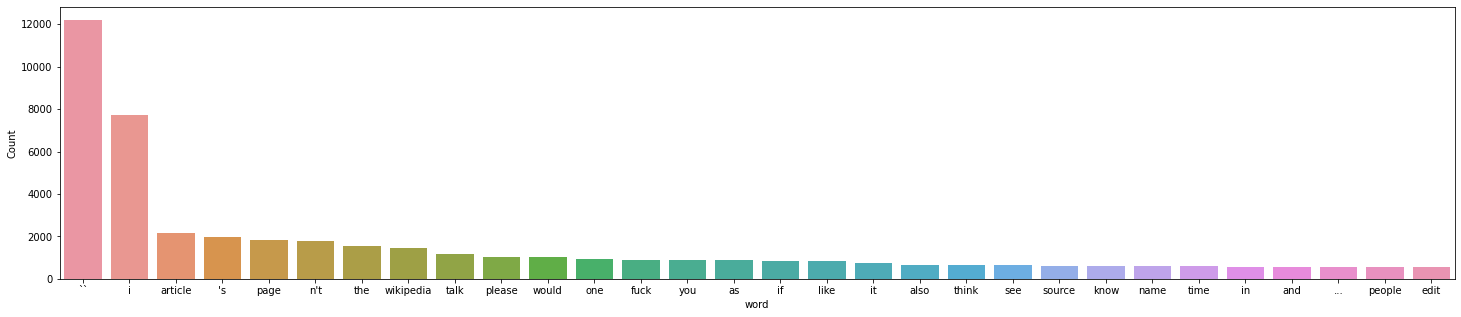

In [42]:
freq_words(df['clean_lemma_pos'])